In [31]:
import os, sys, re
sys.path.append(os.path.dirname(os.getcwd()))
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch
import torchcde
import h5py
from scipy.signal import find_peaks
import MulensModel as mm
import corner
from model.utils import getfsfb
from matplotlib.offsetbox import AnchoredText

from scipy.signal import medfilt
from PyAstronomy.pyasl import binningx0dt

from model.locator import Locator
from model.cde_mdn import CDE_MDN

torch.random.manual_seed(42)
np.random.seed(42)
plt.rcParams["font.family"] = "serif"
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rc('font', size=14)

In [87]:
t_start = 8180
t_end = 8380
eventname = 'KB180800'

In [88]:
data_orig = np.loadtxt('./KMT/%s/%s_aligned.csv'%(eventname, eventname), delimiter=',', skiprows=1, usecols=(2, 5, 6))
order = np.argsort(data_orig[:, 0])
data_orig = data_orig[order]
err = data_orig[:, -1]
x = data_orig[:, :-1]

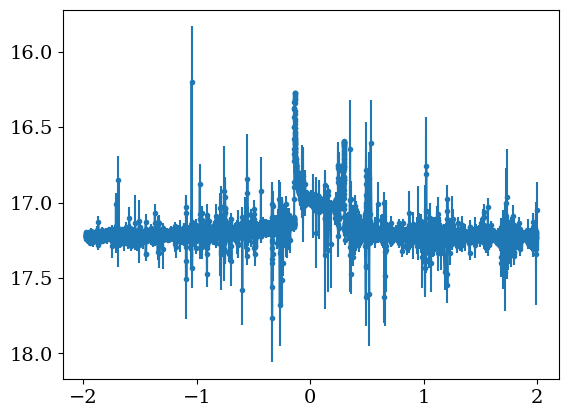

In [89]:
# t0, tE = pred_t[0]
t0, tE = [8280.102654, 40.558097]
x[:, 0] = (x[:, 0] - t0)/tE
## -2 < tau < 2
ind = (x[:, 0] > -2) * (x[:, 0] < 2)
mbase = x[~ind, 1].mean()
x = x[ind]
err = err[ind]

fig, ax = plt.subplots(1, 1)
ax.errorbar(x[:, 0], x[:, 1], err, marker='o', markersize=3)
ax.invert_yaxis()
plt.show()

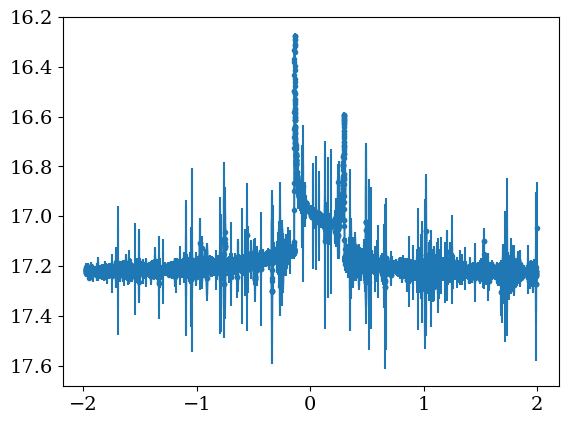

10306


In [90]:
## Perform a median filter on an N-dimensional array.
x[:, 1] = medfilt(x[:, 1], 5)
fig, ax = plt.subplots(1, 1)
ax.errorbar(x[:, 0], x[:, 1], err, marker='o', markersize=3)
ax.invert_yaxis()
plt.show()
print(len(x))

10127


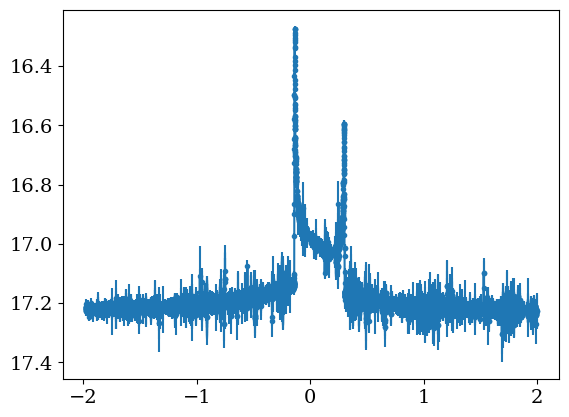

In [91]:
## merr < 0.1
threhold = 0.1
ind = err<0.1
print(len(err[ind]))

x = x[ind]
err = err[ind]
fig, ax = plt.subplots(1, 1)
ax.errorbar(x[:, 0], x[:, 1], err, marker='o', markersize=3)
ax.invert_yaxis()
plt.show()

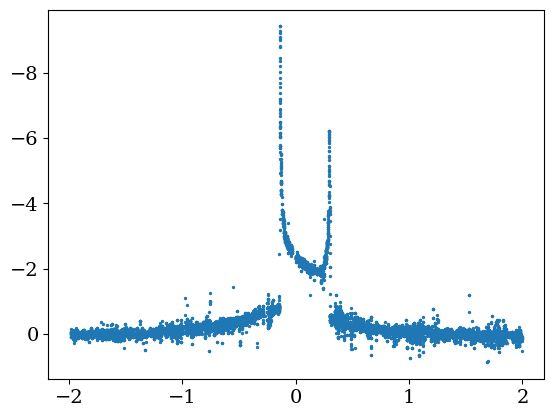

In [177]:
## align mag ##
mag_aligned = x.copy()
mag_aligned[:, 1] = (x[:, 1] - mbase) / 0.1
fig, ax = plt.subplots(1, 1)
ax.scatter(mag_aligned[:, 0], mag_aligned[:, 1], marker='o', s=2)
ax.invert_yaxis()

1479


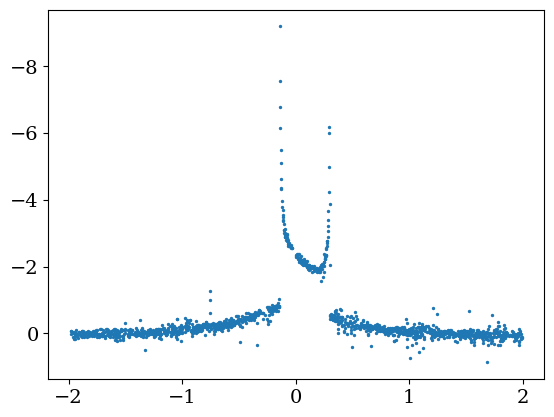

In [178]:
mag_binned, dt = binningx0dt(mag_aligned[:, 0], mag_aligned[:, 1], reduceBy=5, yvalFunc=np.median)
mag_binned = mag_binned[:, :2]
print(len(mag_binned))
fig, ax = plt.subplots(1, 1)
ax.scatter(mag_binned[:, 0], mag_binned[:, 1], marker='o', s=2)
ax.invert_yaxis()

In [262]:
## apply the log_signature transform
data = torch.tensor(mag_aligned.reshape(1, *mag_aligned.shape))
# data = torch.tensor(mag_binned.reshape(1, *mag_binned.shape))
# depth = 3; window_length = 4
depth = 3; window_length = 16
print(data.shape)
data = torchcde.logsig_windows(data, depth, window_length=window_length)
print(data.shape)
train_coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(data)

torch.Size([1, 10127, 2])
torch.Size([1, 634, 5])


In [263]:
checkpt = torch.load('experiments/estimator/estimator_l32nG12diag.ckpt', map_location='cpu')
ckpt_args = checkpt['args']
state_dict = checkpt['state_dict']
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

output_dim = 5
input_dim = data.shape[-1]
latent_dim = ckpt_args.latents

model = CDE_MDN(input_dim, latent_dim, output_dim).to(device)
model_dict = model.state_dict()

# 1. filter out unnecessary keys
state_dict = {k: v for k, v in state_dict.items() if k in model_dict}
# 2. overwrite entries in the existing state dict
model_dict.update(state_dict) 
# 3. load the new state dict
model.load_state_dict(state_dict)
model.to(device)

CDE_MDN(
  (cde_func): CDEFunc(
    (linear1): Linear(in_features=32, out_features=1024, bias=True)
    (relu1): PReLU(num_parameters=1)
    (resblocks): Sequential(
      (0): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): PReLU(num_parameters=1)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (1): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): PReLU(num_parameters=1)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (2): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): PReLU(num_parameters=1)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
    )
    (relu2): PReLU(num_parameters=1)
    (linear2): Linear(in_features=1024, out_features=160, bias=True)
    (tanh): Tanh()
    (linear3): Linear(in_features=

In [236]:
with torch.no_grad():
    pi, normal = model(train_coeffs.float().to(device))

In [237]:
n = int(1e6)

pi_ = pi.probs.cpu(); loc_ = normal.loc.cpu(); scale_ = normal.scale.cpu()
pi_ = torch.tile(pi_, (n, 1))
loc_ = torch.tile(loc_, (n, 1, 1))
scale_ = torch.tile(scale_, (n, 1, 1))
normal_dist = torch.distributions.Normal(loc_, scale_)
pi_dist = torch.distributions.OneHotCategorical(probs=pi_)
sample = model.sample(pi_dist, normal_dist).numpy()

In [238]:
print(len(x))
print(len(err))

10127
10127


/tmp/ipykernel_1892/2198000913.py:7: RuntimeWarning: invalid value encountered in log10
  test_p[0][-1] = np.log10(fs / (fs + fb))


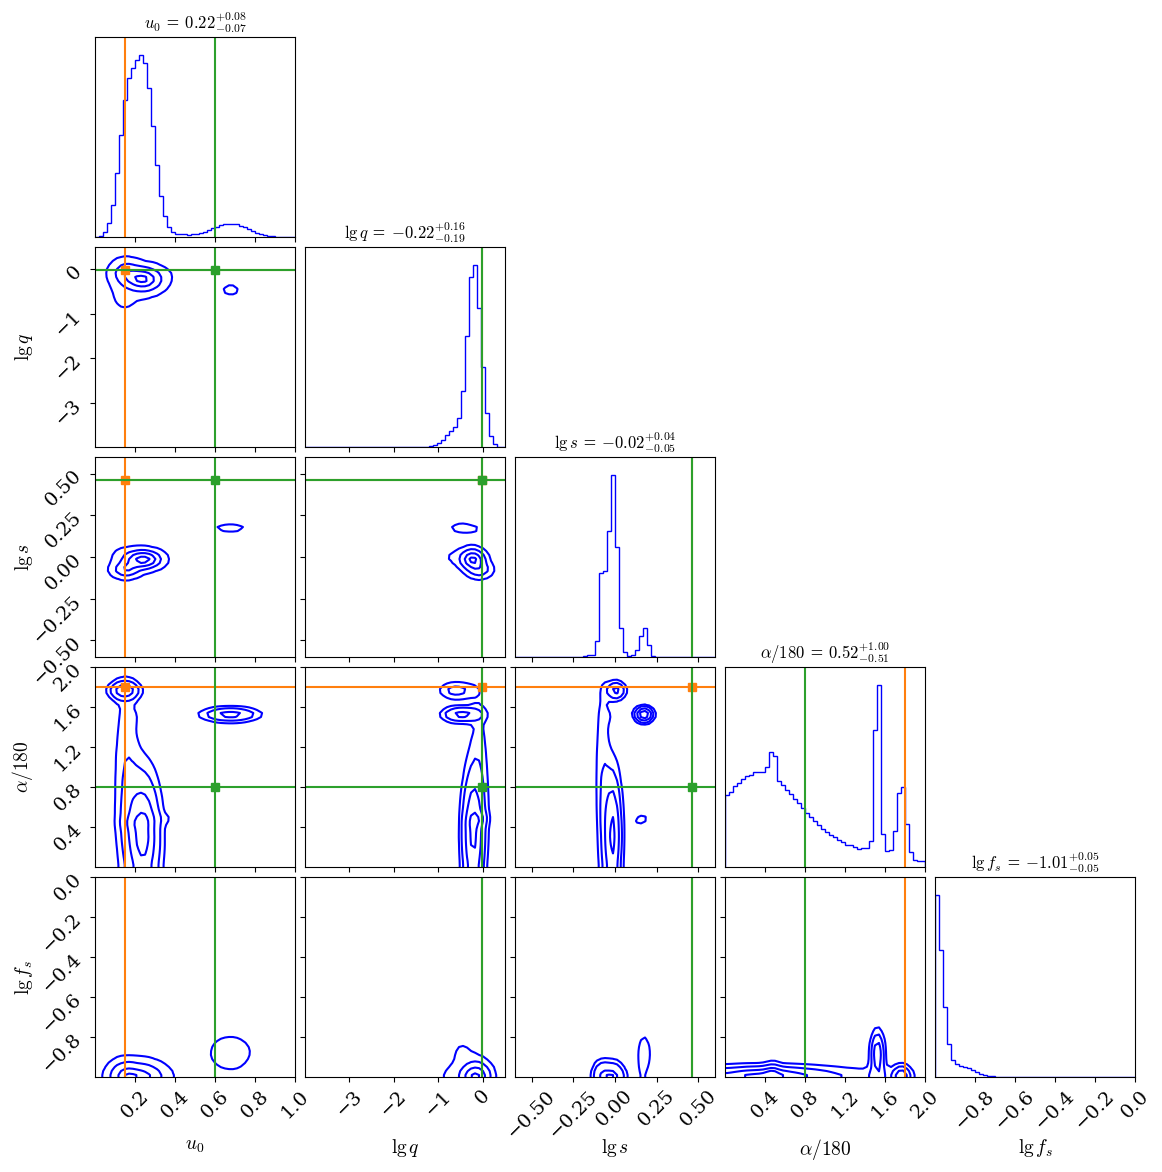

In [239]:
# x = mag_aligned
# err = err

test_p = [[0.15, 1e-3, -0.01, 0.46, 1.8, 0],
        [0.6, 1e-3, -0.01, 0.46, 0.8, 0]]
fs, fb = getfsfb(x[:, 0], 10**(x[:, 1]/5/(-2.5)), err/(2.5*np.log(10))*10**(x[:, 1]/5/(-2.5)), 0, 1, *test_p[0][:-1])[1:3]
test_p[0][-1] = np.log10(fs / (fs + fb))
fs, fb = getfsfb(x[:, 0], 10**(x[:, 1]/5/(-2.5)), err/(2.5*np.log(10))*10**(x[:, 1]/5/(-2.5)), 0, 1, *test_p[1][:-1])[1:3]
test_p[1][-1] = np.log10(fs / (fs + fb))
truths_full = np.array(test_p)
truths = np.delete(truths_full, 1, axis=-1)

range_p = [(0, 1), (-4, 0.5), (-0.6, 0.6), (0, 2), (-1, 0)]
# range_p = None
sigma_level = 1-np.exp(-0.5)
fig = corner.corner(sample, labels=[r"$u_0$", r"$\lg q$", r"$\lg s$", r"$\alpha/180$", r"$\lg f_s$"],
            smooth=1,
            bins=50,
            range=range_p,
            show_titles=True, title_kwargs={"fontsize": 12},
            truths=truths[0], truth_color='C1', 
            fill_contours=False, color='blue', no_fill_contours=True,
            plot_datapoints=False, plot_density=False,
            )
corner.overplot_lines(fig, truths[1], color="C2")
corner.overplot_points(fig, truths[1][None], marker="s", color="C2")
plt.show()

In [240]:
def prepare_lc_mdn(pis, locs):
    # mag = X[:, :, 1] + 18
    # flux = 10 ** (0.4 * (18 - mag))
    # merr = torch.ones_like(mag) * 0.033
    # ferr = merr*flux*np.log(10)/2.5
    # # times, mag, flux, ferr
    # lc = torch.stack([X[:, :, 0], mag, flux, ferr], dim=-1)
    first_indices = torch.arange(len(pis))[:, None]
    order = torch.argsort(pis, dim=-1, descending=True)
    pis = pis[first_indices, order]
    locs = locs[first_indices, order]
    return pis.numpy(), locs.numpy()

[[[8.17122804e+03 1.72398210e+01 3.31890000e-02]
  [8.17125482e+03 1.72865070e+01 2.93840000e-02]
  [8.17224687e+03 1.72025990e+01 2.07980000e-02]
  ...
  [8.40526874e+03 1.72787130e+01 1.61839000e-01]
  [8.40529241e+03 1.71997860e+01 3.11240000e-02]
  [8.40530154e+03 1.72138580e+01 3.72340000e-02]]]


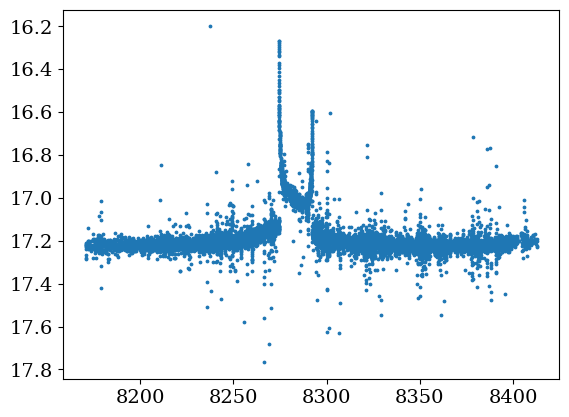

In [241]:
lc = np.loadtxt('./KMT/%s/%s_aligned.csv'%(eventname, eventname), delimiter=',', skiprows=1, usecols=(2, 5, 6)).reshape(1, -1, 3)
lc[:, :, 1] = lc[:, :, 1]
print(lc)

fig, ax = plt.subplots(1, 1)
ax.scatter(lc[:, :, 0], lc[:, :, 1], s=3)
ax.invert_yaxis()
plt.show()

In [242]:
pis_sort, locs_sort = prepare_lc_mdn(pi.probs.cpu(), normal.loc.cpu())

In [243]:
print(pis_sort)

[[5.9761131e-01 2.1302600e-01 8.3115295e-02 6.0946684e-02 1.2119065e-02
  1.0566000e-02 9.7013637e-03 5.6285611e-03 3.4137873e-03 2.4452910e-03
  1.2560107e-03 1.7055757e-04]]


In [244]:
print(locs_sort)

[[[ 0.2418494  -0.2255204  -0.01445288  0.3082712  -1.0253571 ]
  [ 0.15452942 -0.0671458  -0.07646707  0.8998665  -0.9904372 ]
  [ 0.6775162  -0.4652651   0.17497174  1.52466    -0.87935704]
  [ 0.14671896 -0.5986369   0.00661022  1.7652804  -1.0073521 ]
  [ 0.15356013 -0.23074783 -0.1271019   1.2460175  -0.99736774]
  [ 0.26263773 -0.7030559  -0.02282402  1.5165846  -1.0329876 ]
  [ 0.40646178 -0.04838924  0.16936432  0.48366725 -0.98442805]
  [ 0.20324634 -0.21203768  0.13206355  0.4439136  -1.000426  ]
  [ 0.39704293 -0.36818805  0.10277638  1.5492461  -0.9476498 ]
  [ 0.15022783 -0.4003425   0.03778505  0.34799004 -1.0244122 ]
  [ 0.11320192 -0.6315969  -0.04511079  0.5129095  -1.0866617 ]
  [ 0.14849824 -0.62906605 -0.04228043  1.1628085  -1.0204878 ]]]


In [245]:
i = 0
index = 0
para_initial = locs_sort[i, index, :-1]
para_initial = para_initial.tolist()
para_initial.insert(4, -3)
para_initial.insert(5, t0)
para_initial.insert(6, tE)
print(para_initial)
# para_initial = [0.120848, 0.005505, -0.080019, 0.311, -3, 8280.102654, 40.558097]

[0.2418493926525116, -0.22552040219306946, -0.014452876523137093, 0.308271199464798, -3, 8280.102654, 40.558097]


In [246]:
import VBBinaryLensing
def get_fs_fb(amp, flux, ferr, return_fmod=False):
    sig2 = ferr**2
    wght = flux/sig2
    d = np.ones(2)
    d[0] = np.sum(wght*amp)
    d[1] = np.sum(wght)
    b = np.zeros((2,2))
    b[0,0] = np.sum(amp**2/sig2)
    b[0,1] = np.sum(amp/sig2)
    b[1,0] = b[0,1]
    b[1,1] = np.sum(1./sig2)
    c = np.linalg.inv(b)
    fs = np.sum(c[0]*d)
    fb = np.sum(c[1]*d)
    fserr = np.sqrt(c[0,0])
    fberr = np.sqrt(c[1,1])
    fmod = fs*amp+fb
    chi2 = np.sum((flux-fmod)**2/sig2)
    if return_fmod:
        return chi2, fs, fb, fmod
    return chi2, fs, fb, fserr, fberr

def compute_amp(time_array, fitting_parameters, VBBL=VBBinaryLensing.VBBinaryLensing()):
    u0, lgq, lgs, ad180, lgrho, t0, te = fitting_parameters[:]
    q, s, rho = 10**lgq, 10**lgs, 10**lgrho
    alpha = ad180 * np.pi # convert to radian
    tau = (time_array-t0)/te
    xs = tau*np.cos(alpha) - u0*np.sin(alpha)
    ys = tau*np.sin(alpha) + u0*np.cos(alpha)
    magnifications = np.array([VBBL.BinaryMag2(s, q, xs[i], ys[i], rho) for i in range(len(xs))])
    return magnifications

In [247]:
print(lc)

[[[8.17122804e+03 1.72398210e+01 3.31890000e-02]
  [8.17125482e+03 1.72865070e+01 2.93840000e-02]
  [8.17224687e+03 1.72025990e+01 2.07980000e-02]
  ...
  [8.40526874e+03 1.72787130e+01 1.61839000e-01]
  [8.40529241e+03 1.71997860e+01 3.11240000e-02]
  [8.40530154e+03 1.72138580e+01 3.72340000e-02]]]


<ErrorbarContainer object of 3 artists>

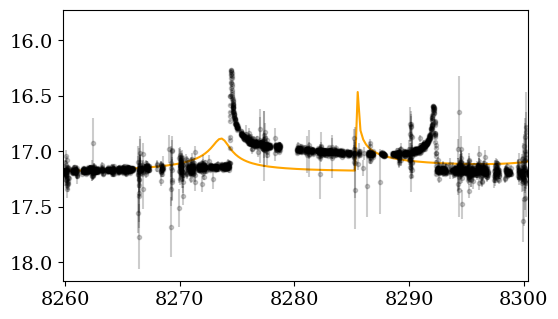

In [248]:
from re import T


date = lc[:, :, 0][0]
mag = lc[:, :, 1][0]
# flux = lc[:, :, 2]
# ferr = lc[:, :, 3]
merr = lc[:, :, 2][0]
flux = 10**(0.4*(18-mag))
ferr = merr*flux*np.log(10)/2.5

magnification = compute_amp(date, para_initial)
chi2, fs, fb, fmod = get_fs_fb(magnification, flux, ferr, return_fmod=True)

tmod = np.linspace(min(date), max(date), 1000)
magnification = compute_amp(tmod, para_initial)
fmod = fs*magnification + fb
mmod = 18 - 2.5*np.log10(fmod)

fig = plt.figure(1, (6, 12))
plt.xlabel(r'HJD-2450000', fontsize=20)
plt.ylabel(r'$m$', fontsize=20)

ax_lc = plt.subplot2grid(shape=(3, 3), loc=(0, 0), rowspan=1, colspan=3)
ax_lc.invert_yaxis()
ax_lc.set_xlim(t0-0.5*tE, t0+0.5*tE)

ax_lc.plot(tmod, mmod, color='orange', linestyle='-')
ax_lc.errorbar(x=date, y=mag, yerr=merr, fmt='o ', markersize=3, alpha=0.2, color='black')

In [249]:
print(mag)

[17.239821 17.286507 17.202599 ... 17.278713 17.199786 17.213858]


In [250]:
from scipy.optimize import fmin
def compute_chisq(fitting_parameters, time, flux, ferr, VBBL, return_model=False, rho=None, return_lc=False):
        magnifications = compute_amp(time, fitting_parameters, VBBL)
        chi2, fs, fb, fserr, fberr = get_fs_fb(magnifications, flux, ferr)
        if return_lc:
            time_model = np.arange(time.min(), time.max(), 0.001)
            magnifications = compute_amp(time_model, fitting_parameters, VBBL)
            mag_model = 18 - 2.5*np.log10(magnifications*fs + fb)
            model = np.vstack((time_model, mag_model))
            return chi2, fs, fb, model
        if return_model:
            return chi2, fs, fb
        return chi2

def perform_optimization(time, flux, ferr, para_initial, verbose=True):
    VBBL = VBBinaryLensing.VBBinaryLensing()

    para_best, chi2_min, iter, funcalls, warnflag, allevcs = fmin(compute_chisq, para_initial, args=(time, flux, ferr, VBBL), full_output=True, retall=True, maxiter=1000, maxfun=5000, disp=verbose)

    chi2_min, fs, fb = compute_chisq(para_initial, time, flux, ferr, VBBL, return_model=True)
    if verbose:
        print('initial chisq: ', chi2_min)
    
    chi2_min, fs, fb, model = compute_chisq(para_best, time, flux, ferr, VBBL, return_lc=True)
    if verbose:
        print('best chisq & (fs, fb): ', chi2_min, fs, fb)
    return para_best, chi2_min, model, warnflag

In [251]:
dof = len(date)

best_parameters = []
colors = ['orange', 'green', 'black']
labels = ['close', 'wide', 'black']
linestyle = ['-', 'dashed', '-']
minimum_chi2 = np.inf

# downhill
param_best, chi2_min, model, warnfalg = perform_optimization(date, flux, ferr, para_initial)

if chi2_min < minimum_chi2:
    minimum_chi2 = chi2_min
print(param_best)


Optimization terminated successfully.
         Current function value: 243559.963200
         Iterations: 795
         Function evaluations: 1368
initial chisq:  344081.8120120987
best chisq & (fs, fb):  243559.96320036228 0.0933145743866568 1.9596804547128643
[ 2.48885098e-01 -2.12091752e-01 -1.46736736e-02  3.06560181e-01
 -3.32648763e+00  8.28223208e+03  4.10896522e+01]


<ErrorbarContainer object of 3 artists>

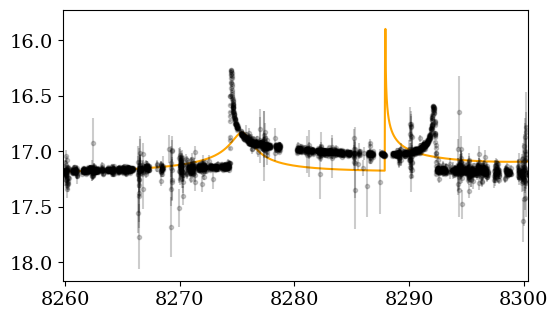

In [252]:
fig = plt.figure(1, (6, 12))
plt.xlabel(r'HJD-2450000', fontsize=20)
plt.ylabel(r'$m$', fontsize=20)

ax_lc = plt.subplot2grid(shape=(3, 3), loc=(0, 0), rowspan=1, colspan=3)
ax_lc.invert_yaxis()
ax_lc.set_xlim(t0-0.5*tE, t0+0.5*tE)

order = np.argsort(date)
date = date[order]
mag=mag[order]
merr = merr[order]

ax_lc.plot(model[0], model[1], label=r'%s, $\chi^2$=%.1f'%(labels[index], chi2_min / minimum_chi2 * dof), color=colors[index], linestyle=linestyle[index])
ax_lc.errorbar(x=date, y=mag, yerr=merr, fmt='o ', markersize=3, alpha=0.2, color=colors[-1])

In [253]:
def simulate_lc(
        parameters, time_settings,
        coords=None, methods=None,
        flux_source=1000., flux_blending=0.,
        relative_uncertainty=0.01,
        plot=True):
    """
    Simulate and save light curve.

    Parameters :
        parameters: *dict*
            Parameters of the model - keys are in MulensModel format, e.g.,
            't_0', 'u_0', 't_E' etc.

        time_settings: *dict*
            Sets properties of time vector. It requires key `type`, which can
            have one of two values:
            - `random` (requires `n_epochs`, `t_start`, and `t_stop`) or
            - `evenly spaced` (settings passed to `Model.set_times()`).

        coords: *str*
            Event coordinates for parallax calculations, e.g.,
            "17:34:51.15 -30:29:28.27".

        methods: *list*
            Define methods used to calculate magnification. The format is
            the same as MulensModel.Model.set_magnification_methods().

        flux_source: *float*
            Flux of source.

        flux_blending: *float*
            Blending flux.

        relative_uncertainty: *float*
            Relative uncertainty of the simulated data (this is close to
            sigma in magnitudes).

        plot: *bool*
            Plot the data and model at the end?

    """
    try:
        model = mm.Model(parameters, coords=coords)

        if time_settings['type'] == 'random':
            raw = np.random.rand(time_settings['n_epochs'])
            dt = time_settings['t_stop'] - time_settings['t_start']
            times = time_settings['t_start'] + np.sort(raw) * dt
        elif time_settings['type'] == 'evenly spaced':
            times = model.set_times(t_start=time_settings['t_start'],
                                        t_stop=time_settings['t_stop'],
                                        n_epochs=time_settings['n_epochs'])
        else:
            raise ValueError("unrecognized time_settings['type']: " +
                            time_settings['type'])

        if methods is not None:
            model.set_magnification_methods(methods)

        magnification = model.get_magnification(times)

        flux = flux_source * magnification + flux_blending
        flux_err = relative_uncertainty * flux

        flux *= 1 + relative_uncertainty * np.random.randn(len(flux))

        data = mm.MulensData([times, flux, flux_err], phot_fmt='flux')
        # event = mm.Event([data], model)
        # print("chi^2: {:.2f}".format(event.get_chi2()))

        # np.savetxt(file_out,
        #            np.array([times, data.mag, data.err_mag]).T,
        #            fmt='%.4f')

        if plot:
            model.plot_lc(t_start=np.min(times), t_stop=np.max(times),
                        source_flux=flux_source, blend_flux=flux_blending)
            data.plot(phot_fmt='mag')
            # plt.savefig('./test.png')
            plt.show()

        if time_settings['type'] == 'random':
            single = mm.Model({'t_0': parameters['t_0'], 'u_0': parameters['u_0'], 't_E': parameters['t_E']})
            event_single = mm.Event([data], single)
            chi2 = event_single.get_chi2()
            # print("chi^2 single: {:.2f}".format(chi2))

            if chi2 > 1000:
                # plt.plot(data.mag+np.log10(flux)*2.5)
                # plt.show()
                return np.stack([times, data.mag, data.err_mag], axis=-1).reshape(1, -1, 3)
            else: 
                return None
        else:
            return np.stack([times, data.mag], axis=-1).reshape(1, -1, 2)
    except:
        print('Error occurred, but continue')
        return None

In [254]:
print(param_best)

[ 2.48885098e-01 -2.12091752e-01 -1.46736736e-02  3.06560181e-01
 -3.32648763e+00  8.28223208e+03  4.10896522e+01]


/home/ellahu/anaconda3/envs/MAGIC/lib/python3.9/site-packages/MulensModel/magnificationcurve.py:179: UserWarning: no finite-source method is set
  warnings.warn('no finite-source method is set', UserWarning)


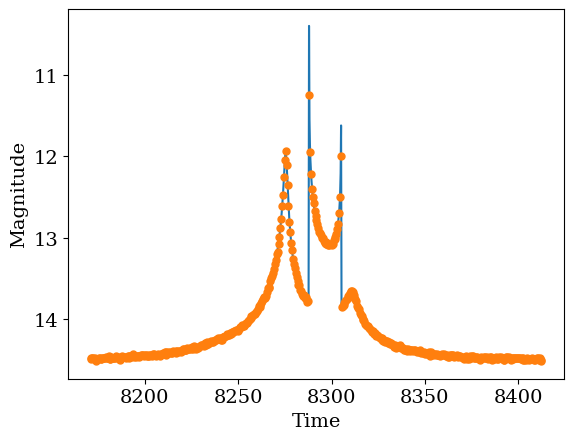

array([[[8170.83516   ,   14.48868722],
        [8171.31954559,   14.47930643],
        [8171.80393118,   14.47846293],
        [8172.28831677,   14.47322452],
        [8172.77270236,   14.49296658],
        [8173.25708796,   14.47128305],
        [8173.74147355,   14.50713285],
        [8174.22585914,   14.48388864],
        [8174.71024473,   14.48199853],
        [8175.19463032,   14.46947941],
        [8175.67901591,   14.47573172],
        [8176.1634015 ,   14.49098329],
        [8176.64778709,   14.48599202],
        [8177.13217269,   14.47271303],
        [8177.61655828,   14.47534336],
        [8178.10094387,   14.48040003],
        [8178.58532946,   14.47892936],
        [8179.06971505,   14.46575862],
        [8179.55410064,   14.4785136 ],
        [8180.03848623,   14.47341462],
        [8180.52287182,   14.44872159],
        [8181.00725741,   14.48716152],
        [8181.49164301,   14.49144298],
        [8181.9760286 ,   14.46222075],
        [8182.46041419,   14.47762705],


In [255]:
param = {
    't_0': param_best[5], 
    'u_0': param_best[0],
    't_E': param_best[6], 
    'rho': 1e-3, 
    'q': 10**(param_best[1]), 
    's': 10**(param_best[2]),
    'alpha': param_best[3]*180}
time = {
    'type':'evenly spaced',
    't_start':min(date),
    't_stop':max(date),
    'n_epochs':500
}
simulate_lc(param, time)